In [1]:
!pip3 install pulp

In [2]:
import pandas as pd
import pulp
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from scipy.optimize import curve_fit

In [3]:
df = pd.read_csv("player_sample.csv")

In [4]:
df["Price"] = df["Price"].fillna(0)

# Part 1

## Q1

### Naive Approach

Assume the single price will be one of the largest price each player paid across all substitutable booster packs

In [5]:
N1 = 10000
N2 = 2000000
demand = df["Price"].value_counts().to_frame().reset_index().rename(columns = {"index": "Price", "Price": "Frequency"})
demand = demand.sort_values("Price", ascending=False)
demand["pdf"] = demand["Frequency"]/sum(demand["Frequency"])
demand["cdf"] = demand["pdf"].cumsum()
demand["expected_demand"] = N2 * demand["cdf"]
demand["expected_revenue"] = demand["Price"]*demand["expected_demand"]
demand

,Price,Frequency,pdf,cdf,expected_demand,expected_revenue
4,12.0,368,0.0368,0.0368,73600.0,883200.0
12,11.0,11,0.0011,0.0379,75800.0,833800.0
11,10.0,21,0.0021,0.0400,80000.0,800000.0
10,9.0,30,0.0030,0.0430,86000.0,774000.0
9,8.0,34,0.0034,0.0464,92800.0,742400.0
2,7.0,479,0.0479,0.0943,188600.0,1320200.0
1,6.0,1173,0.1173,0.2116,423200.0,2539200.0
5,5.0,185,0.0185,0.2301,460200.0,2301000.0
8,4.0,59,0.0059,0.2360,472000.0,1888000.0
7,3.0,72,0.0072,0.2432,486400.0,1459200.0


The Naive Approach gives an expected revenue of 2,539,200 with a single price of $6.0. 

Trade-offs: 
- Advantage: a value-based perspective with consideration of customers' willingness to pay, easy to implement 
- Disadvatage: we are assuming the price should set to be one of largest prices that customers gave in the survey. This is a strong assumption. The prices in reality can be set as a continous value. 


### Parametric Approach

In the parametric approach, we tried to find a function to represent the expected demand by fitting a polynomial and logit curve to cdf.
The formula we leveraged is d(p) = N*(1-F(p)). Note the F(p) is the cdf. (This models any demand function)


1. polynomial 
2. logit 

In [8]:
# percent of interest is the percentage of people who has responded with a non-zero price
pct_interest = 1 - demand.loc[demand["Price"] == 0, "pdf"][0]
pct_interest

0.2932

In [9]:
# remove price = 0 as it is agaist our assumption on price
df_param = demand.drop([0], axis = 0).reset_index(drop=True)
df_param = df_param[["Price", "Frequency"]]

N1 = 10000
N2 = 2000000

df_param["pdf"] = df_param["Frequency"]/sum(df_param["Frequency"])
df_param["cdf"] = df_param["pdf"].cumsum()
df_param["expected_demand"] = N2 * pct_interest * df_param["cdf"]
df_param["expected_revenue"] = df_param["Price"]*df_param["expected_demand"]
df_param

,Price,Frequency,pdf,cdf,expected_demand,expected_revenue
0,12.0,368,0.125512,0.125512,73600.0,883200.0
1,11.0,11,0.003752,0.129263,75800.0,833800.0
2,10.0,21,0.007162,0.136426,80000.0,800000.0
3,9.0,30,0.010232,0.146658,86000.0,774000.0
4,8.0,34,0.011596,0.158254,92800.0,742400.0
5,7.0,479,0.163370,0.321623,188600.0,1320200.0
6,6.0,1173,0.400068,0.721692,423200.0,2539200.0
7,5.0,185,0.063097,0.784789,460200.0,2301000.0
8,4.0,59,0.020123,0.804911,472000.0,1888000.0
9,3.0,72,0.024557,0.829468,486400.0,1459200.0


In [10]:
df_param.loc[df_param["expected_revenue"] == df_param["expected_revenue"].max()]

,Price,Frequency,pdf,cdf,expected_demand,expected_revenue
6,6.0,1173,0.400068,0.721692,423200.0,2539200.0


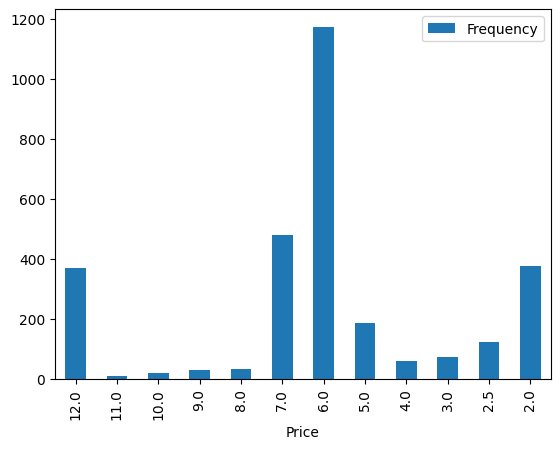

In [11]:
df_param.plot(x="Price", y="Frequency", kind="bar")
plt.show()

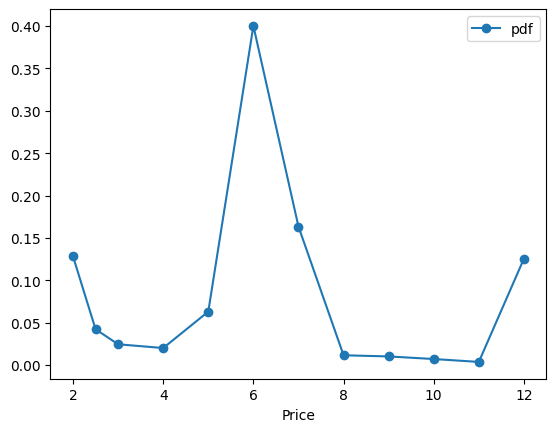

In [12]:
# pdf
df_param.plot(x="Price", y="pdf", kind="line", marker = "o")
plt.show()

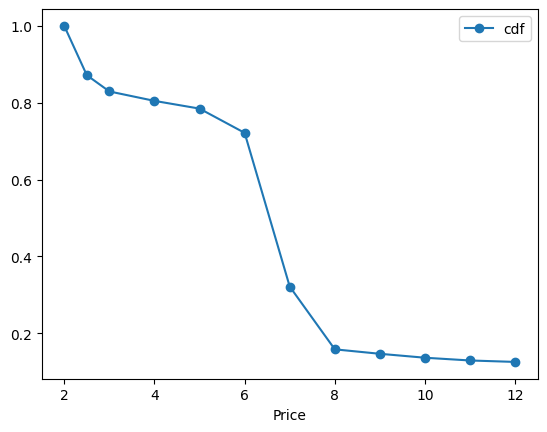

In [13]:
# cdf
df_param.plot(x="Price", y="cdf", kind="line", marker = "o")
plt.show()

#### 1. Fit Polynomial Regression

[0.3419592465322497, 0.11277779471963133, 0.1041967112481973, 0.07737872634404655, 0.07737773737969275, 0.04640776321984298, 0.041632514235935204, 0.03019917953945574, 0.029281115800142806, 0.018448653629098918, 0.018444161295698317, 2.2179579434467197e-09]


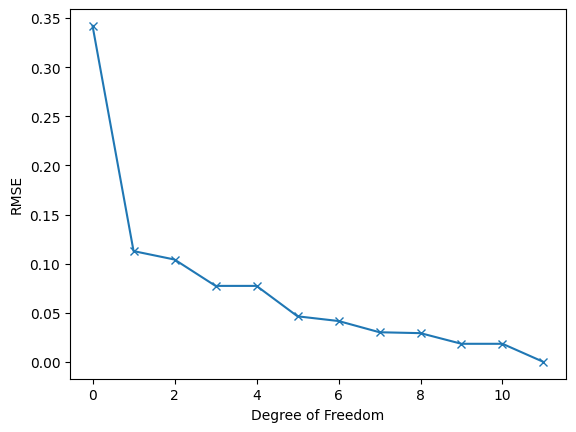

In [55]:
# fit a polynomial curve with least RMSE
import math
x = df_param["Price"]
y = df_param["cdf"]
list_rmse = []
for degree in range(12):
    z = np.polyfit(x,y,degree)
    p = np.poly1d(z)
    mse = np.square(np.subtract(y, p(x))).mean()
    rmse = math.sqrt(mse)
    list_rmse.append(rmse)
plt.plot(list_rmse, marker = "x")
plt.xlabel("Degree of Freedom")
plt.ylabel("RMSE")
print(list_rmse)

poly1d([-4.10629554e-04,  1.43346667e-02, -1.84197954e-01,  1.06894427e+00,
       -2.85682089e+00,  3.69166083e+00])

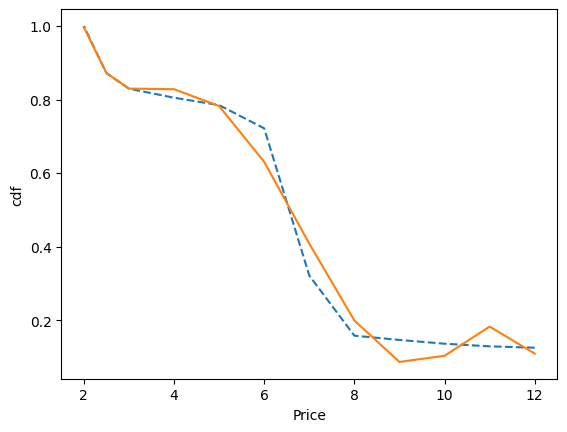

In [16]:
# pick degree = 5 as it is more efficient in fitting the curve and reducing the rmse
z = np.polyfit(x,y, 5)
parameters = np.poly1d(z)
plt.plot(x,y, '--', label='data')
plt.plot( x, parameters(x), '-', label='fit')
plt.xlabel("Price")
plt.ylabel("cdf")
parameters

In [17]:
prices = np.linspace(2,12,200)

In [18]:
def cdf_func(x):
    return parameters(x)  

In [19]:
revenues = []
for price in prices:
    demand = N2 * pct_interest * cdf_func(price)
    revenue = demand * price
    revenues.append(revenue)

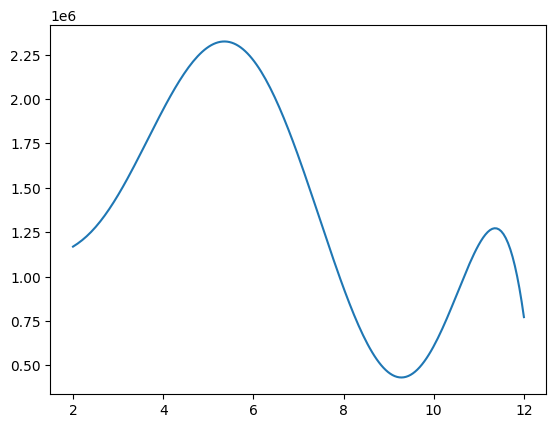

In [20]:
plt.plot(prices, revenues)

In [21]:
print("Optimal Single Price: " + str(prices[revenues.index(max(revenues))]))
print("Expected Max Revenue: " + str(max(revenues)))

Optimal Single Price: 5.366834170854272
Expected Max Revenue: 2324948.556175245


The max revenue is 2,324,948 with the price set to be 5.37. Note that this is lower than the Naive Approach mainly due to the noise when fitting the cdf function. We will try the logit function below. 

cdf is not increasing.

#### 2. Fit Logit Function

In [22]:
def logit_func(x,L, x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

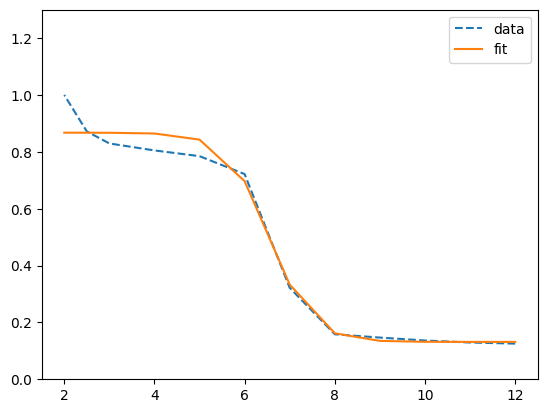

In [23]:
p0 = [max(y), np.median(x), 1, min(y)]
popt, pcov = curve_fit(logit_func, x, y, p0, method = 'dogbox')
predicted_y = logit_func(x, *popt)

plt.plot(x, y, '--', label='data')
plt.plot(x, predicted_y, '-', label='fit')
plt.ylim(0, 1.3)
plt.legend(loc='best')

In [24]:
def cdf_func(x):
    return logit_func(x, *popt)

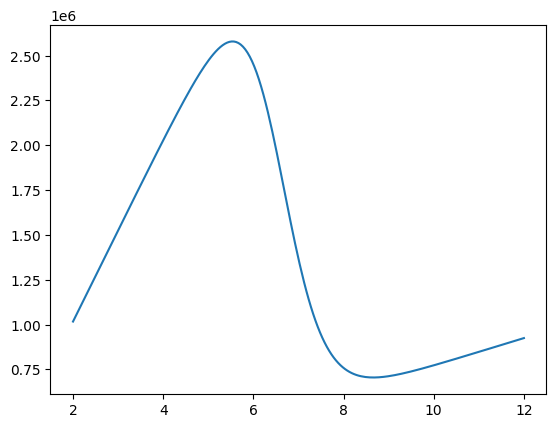

In [25]:
revenues = []
for price in prices:
    demand = N2 * pct_interest * cdf_func(price)
    revenue = demand * price
    revenues.append(revenue)
plt.plot(prices, revenues)

In [26]:
print("Optimal Single Price: " + str(prices[revenues.index(max(revenues))]))
print("Expected Max Revenue: " + str(max(revenues)))

Optimal Single Price: 5.517587939698492
Expected Max Revenue: 2578636.1147789834


The max revenue is 2,578,636 with the price set to be 5.52. Note that this is higher than both the Naive Approach and the Parametric Approach with polynomial fit. We will adopt this approach as it's giving the highest revenue. 

# Q2

### Descriptive Analysis

<Axes: xlabel='Age'>

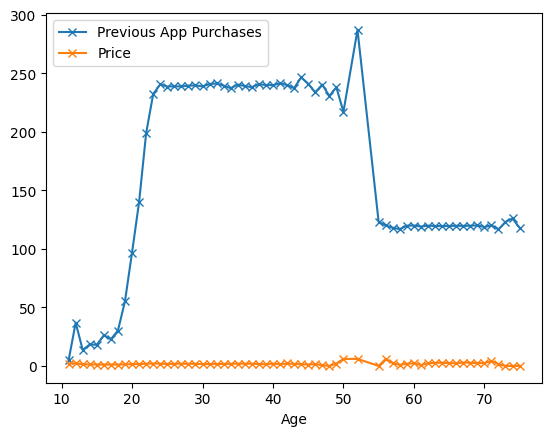

In [27]:
df.groupby(by="Age").mean().plot(kind="line", marker = "x")

<Axes: xlabel='Previous App Purchases'>

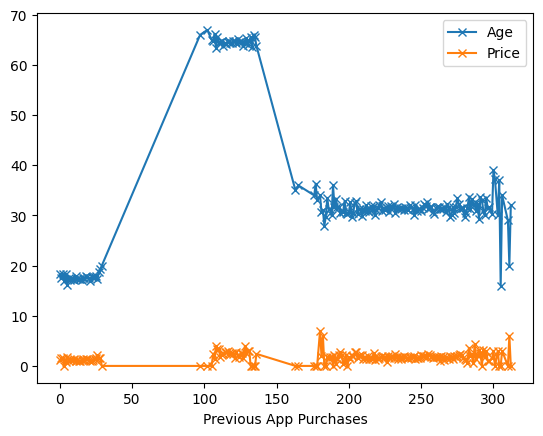

In [28]:
df.groupby(by="Previous App Purchases").mean().plot(kind="line", marker = "x")

### K-Means Clustering

In [29]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

x = df[["Age", "Previous App Purchases"]]
scaler = preprocessing.StandardScaler().fit(x)
x = scaler.transform(x)

seed = 42
kmeans = KMeans(n_clusters=3, random_state=seed) # number of clusters = 3 observed from previous graphs 
kmeans.fit(x)


KMeans(n_clusters=3, random_state=42)

In [30]:
clusters = kmeans.fit_predict(x)
df_clusters = df.copy()
df_clusters["Clusters"] = clusters
df_clusters.head(10)

,Age,Previous App Purchases,Price,Clusters
0,37,218,6.0,0
1,34,247,6.0,0
2,19,15,4.0,1
3,32,235,7.0,0
4,19,15,2.5,1
5,31,252,0.0,0
6,26,267,6.0,0
7,29,190,7.0,0
8,25,236,0.0,0
9,64,119,0.0,2


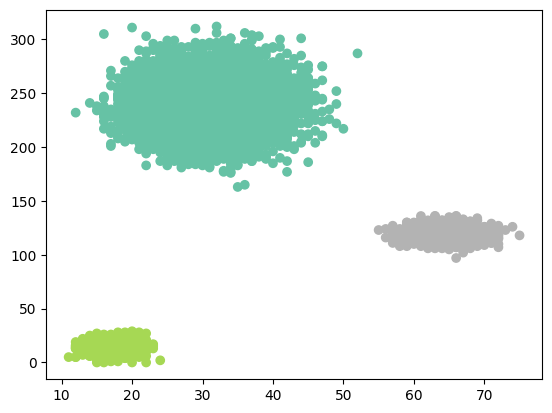

In [31]:
plt.scatter(df_clusters["Age"], df["Previous App Purchases"], c=df_clusters["Clusters"], cmap="Set2")

### Parametric Approach

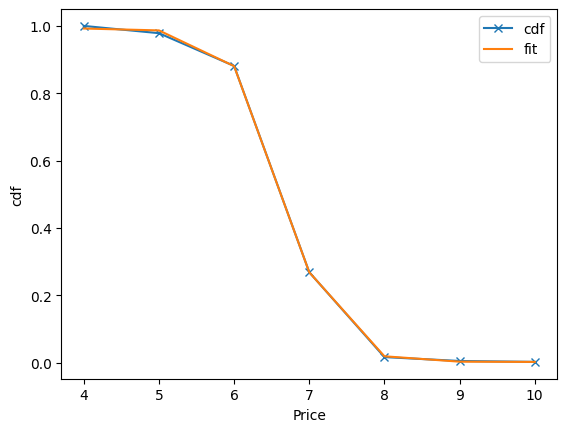

In [32]:
# Cluster 0 - Logit Function
df_cluster0 = df_clusters.loc[df_clusters["Clusters"] == 0].reset_index(drop=True)
df_cluster0.drop(df_cluster0[df_cluster0["Price"] == 0].index, inplace=True) # drop zero price as it cannot be fit as part of logit function
pct_interest = len(df_cluster0)/N1
df_cluster0 = df_cluster0["Price"].value_counts().to_frame().reset_index().rename(columns = {"index": "Price", "Price": "Frequency"})
df_cluster0 = df_cluster0.sort_values("Price", ascending=False)
df_cluster0["pdf"] = df_cluster0["Frequency"]/sum(df_cluster0["Frequency"])
df_cluster0["cdf"] = df_cluster0["pdf"].cumsum()

x = df_cluster0['Price']
y = df_cluster0["cdf"]

plt.plot(x,y, marker = "x", label="cdf")
plt.xlabel("Price")
plt.ylabel("cdf")

p0 = [max(y), np.median(x), 1, min(y)]
popt, pcov = curve_fit(logit_func, x, y, p0, maxfev=10000)

prices = np.linspace(df_cluster0["Price"].min(), df_cluster0["Price"].max(), 200)

def cdf_func(x):
    return logit_func(x, *popt)


plt.plot(x,cdf_func(x), label="fit")
plt.legend()

Optimal Price for Cluster 0: 5.748743718592965
Expected Max Revenue from Cluster 0: 2049798.4780363215


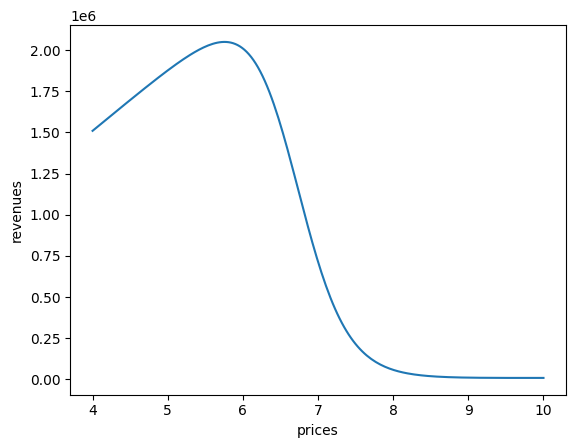

In [33]:
revenues = []
demand0 = []
prices0 = []
for price in prices:
    demand = N2 * pct_interest * cdf_func(price)
    revenue = demand * price
    revenues.append(revenue)
    demand0.append(demand/10) ## For part 2
    prices0.append(price)

plt.plot(prices, revenues)
plt.xlabel("prices")
plt.ylabel("revenues")

r0 = max(revenues)
print("Optimal Price for Cluster 0: " + str(prices[revenues.index(r0)]))
print("Expected Max Revenue from Cluster 0: " + str(r0))

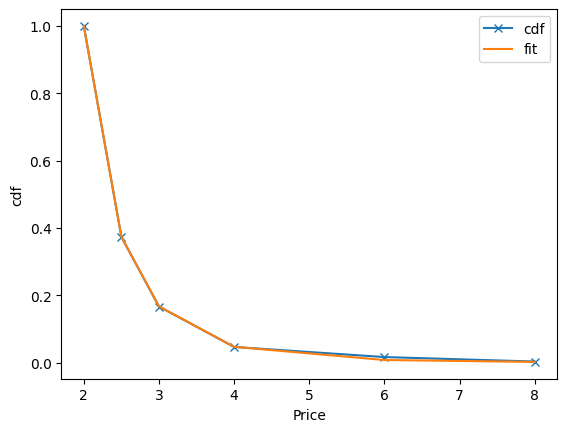

In [34]:
# Cluster 1 - Constant Elasticity
df_cluster1 = df_clusters.loc[df_clusters["Clusters"] == 1].reset_index(drop=True)
df_cluster1.drop(df_cluster1[df_cluster1["Price"] == 0].index, inplace=True)
pct_interest = len(df_cluster1)/N1
df_cluster1 = df_cluster1["Price"].value_counts().to_frame().reset_index().rename(columns = {"index": "Price", "Price": "Frequency"})
df_cluster1 = df_cluster1.sort_values("Price", ascending=False)
df_cluster1["pdf"] = df_cluster1["Frequency"]/sum(df_cluster1["Frequency"])
df_cluster1["cdf"] = df_cluster1["pdf"].cumsum()

x = df_cluster1['Price']
y = df_cluster1["cdf"]

plt.plot(x,y, marker = "x", label="cdf")
plt.xlabel("Price")
plt.ylabel("cdf")

def power_func(x, a, b):
    return a*(x**b)

popt, pcov = curve_fit(power_func, x, y, maxfev = 5000)

prices = np.linspace(df_cluster1["Price"].min(), df_cluster1["Price"].max(), 200)

def cdf_func(x):
    return power_func(x, *popt)


plt.plot(x,cdf_func(x), label="fit")
plt.legend()

Optimal Price for Cluster 1: 2.0
Expected Max Revenue from Cluster 1: 239958.38533695022


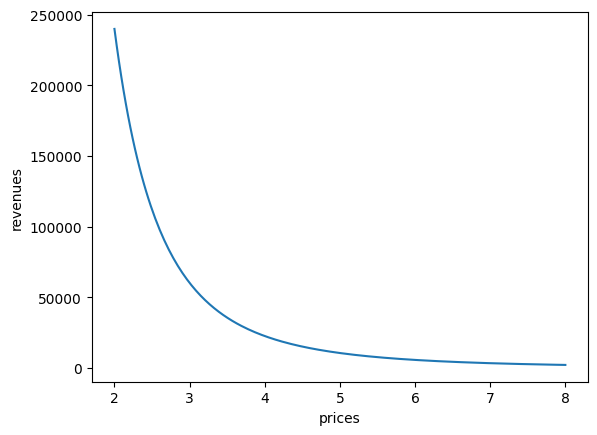

In [35]:
revenues = []
demand1 = []
prices1 = []
for price in prices:
    demand = N2 * pct_interest * cdf_func(price)
    revenue = demand * price
    revenues.append(revenue)
    demand1.append(demand/10) ## For part 2
    prices1.append(price)


plt.plot(prices, revenues)
plt.xlabel("prices")
plt.ylabel("revenues")

r1 = max(revenues)
print("Optimal Price for Cluster 1: " + str(prices[revenues.index(r1)]))
print("Expected Max Revenue from Cluster 1: " + str(r1))

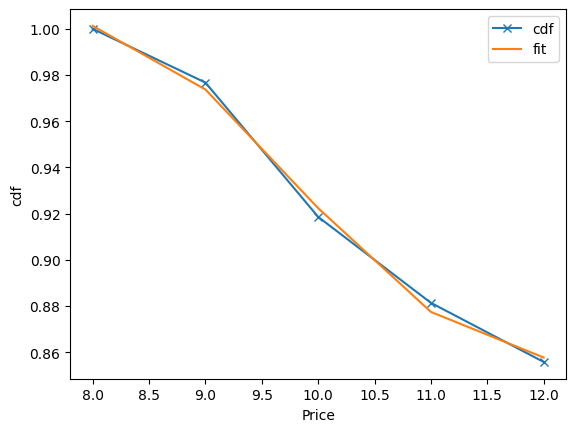

In [36]:
# Cluster 2 - Logit Function
df_cluster2 = df_clusters.loc[df_clusters["Clusters"] == 2].reset_index(drop=True)
df_cluster2.drop(df_cluster2[df_cluster2["Price"] == 0].index, inplace=True)
pct_interest = len(df_cluster2)/N1
df_cluster2 = df_cluster2["Price"].value_counts().to_frame().reset_index().rename(columns = {"index": "Price", "Price": "Frequency"})
df_cluster2 = df_cluster2.sort_values("Price", ascending=False)
df_cluster2["pdf"] = df_cluster2["Frequency"]/sum(df_cluster2["Frequency"])
df_cluster2["cdf"] = df_cluster2["pdf"].cumsum()

x = df_cluster2['Price']
y = df_cluster2["cdf"]
plt.plot(x,y, marker = "x", label="cdf")
plt.xlabel("Price")
plt.ylabel("cdf")

p0 = [max(y), np.median(x), 1, min(y)]
popt, pcov = curve_fit(logit_func, x, y,p0, maxfev=10000)

prices = np.linspace(df_cluster2["Price"].min(), df_cluster2["Price"].max(), 200)

def cdf_func(x):
    return logit_func(x, *popt)

plt.plot(x,cdf_func(x), label="fit")
plt.legend()

Optimal Price for Cluster 2: 12.0
Expected Max Revenue from Cluster 2: 885160.3794585816


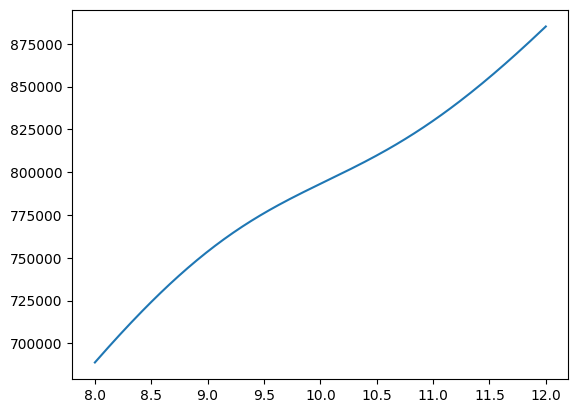

In [37]:
revenues = []
demand2 = []
prices2 = []
for price in prices:
    demand = N2 * pct_interest * cdf_func(price)
    revenue = demand * price
    revenues.append(revenue)
    demand2.append(demand/10) ## For part 2
    prices2.append(price)

plt.plot(prices, revenues)

r2 = max(revenues)
print("Optimal Price for Cluster 2: " + str(prices[revenues.index(r2)]))
print("Expected Max Revenue from Cluster 2: " + str(r2))

In [38]:
# Total 
total_max_revenue = r0 + r1 + r2
print("Expected Max Revenue: " + str(total_max_revenue))

Expected Max Revenue: 3174917.242831853


Using the parametric approach with logit fit, the expected max revenue increased from 2,578,636 to 3,174,402. 

# Part 2

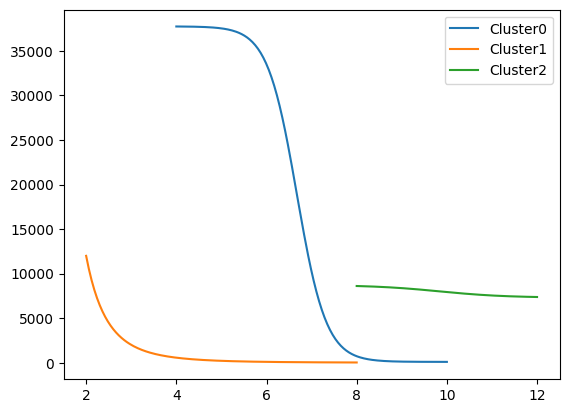

In [39]:
plt.plot(prices0,demand0)
plt.plot(prices1,demand1)
plt.plot(prices2,demand2)

plt.legend(['Cluster0', 'Cluster1', 'Cluster2'])

## Single Base Price

In [40]:
clusters = [0,1,2]
discounts = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]

In [41]:
yvar = pulp.LpVariable.dict("y",(clusters,discounts), cat=pulp.LpBinary)
#Dvar = pulp.LpVariable.dict("d",(clusters,discounts), cat = pulp.LpContinuous)

Dvar0 = {}
Dvar1 = {}
Dvar2 = {}

Pvar = {}


In [42]:

basePrice = 12
maxD = 20000

Model = pulp.LpProblem(name="Model", sense=pulp.LpMaximize)

# Define demand for each cluster at each discount rate
for j in discounts:

    index0 = np.argmin(np.abs(np.array(prices0)- (basePrice - (basePrice*(j/100)))))
    index1 = np.argmin(np.abs(np.array(prices1)- (basePrice - (basePrice*(j/100)))))
    index2 = np.argmin(np.abs(np.array(prices2)- (basePrice - (basePrice*(j/100)))))

    Dvar0[j] = demand0[index0]
    Dvar1[j] = demand1[index1]
    Dvar2[j] = demand2[index2]

    Pvar[j] = basePrice - (basePrice*(j/100))

#Ensure that y value can only equal 1 for each cluster
for i in clusters:
    Model += pulp.lpSum([yvar[(i,j)] for j in discounts]) == 1

#Ensure total demand is not larger than 20,000

Model += pulp.lpSum([yvar[(0,j)]*Dvar0[j] for j in discounts]) + \
pulp.lpSum([yvar[(1,j)]*Dvar1[j] for j in discounts]) + \
pulp.lpSum([yvar[(2,j)]*Dvar2[j] for j in discounts]) <= maxD

# Ensure Price for each cluster is in range of data
Model += pulp.lpSum([yvar[(0,j)]*Pvar[j] for j in discounts]) <= max(prices0)
Model += pulp.lpSum([yvar[(1,j)]*Pvar[j] for j in discounts]) <= max(prices1)
Model += pulp.lpSum([yvar[(2,j)]*Pvar[j] for j in discounts]) <= max(prices2)

# Create Objective Function

obj = pulp.lpSum([yvar[(0,j)]*Dvar0[j]*Pvar[j] for j in discounts]) 
obj += pulp.lpSum([yvar[(1,j)]*Dvar1[j]*Pvar[j] for j in discounts])
obj += pulp.lpSum([yvar[(2,j)]*Dvar2[j]*Pvar[j] for j in discounts]) 


Model += obj

In [43]:
Model.solve()
print("Status:", pulp.LpStatus[Model.status])

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/07e96286d90448bf8ef4265e7d27ed36-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/07e96286d90448bf8ef4265e7d27ed36-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 12 COLUMNS
At line 385 RHS
At line 393 BOUNDS
At line 457 ENDATA
Problem MODEL has 7 rows, 63 columns and 186 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 174122 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 2 strengthened rows, 0 substitutions
Cgl0005I 3 SOS with 40 members
Cgl0004I processed model has 7 rows, 40 columns (40 integer (40 of which binary)) and 120 elements
Cbc0038I Initial state - 2 integers unsatisfied sum -

In [44]:
pulp.value(Model.objective)

147777.86717476856

In [45]:
for i in clusters:
    for j in discounts:
        if yvar[(i,j)].varValue != 0:
            print('Cluster:',i,'Discount:',j,' ',yvar[(i,j)].varValue)

Cluster: 0 Discount: 40   1.0
Cluster: 1 Discount: 80   1.0
Cluster: 2 Discount: 0   1.0


In [46]:
demands = [Dvar0,Dvar1,Dvar2]

for i in clusters:
    for j in discounts:
        if yvar[(i,j)].varValue != 0:
            Price = round(Pvar[j],2) 
            demand = demands[i][j]
            print('Cluster:',i,'Price:', Price, 'Demand:', demand)

Cluster: 0 Price: 7.2 Demand: 6414.478661437885
Cluster: 1 Price: 2.4 Demand: 5448.992861065688
Cluster: 2 Price: 12.0 Demand: 7376.336495488179


## Loop Base Price

In [47]:
clusters = [0,1,2]
discounts = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]

In [48]:
maxRev = 0
optBase = 2
OptDisc = [0,0,0]
OptDemand = [0,0,0]
OptPrices = [0,0,0]

start = 2
end = 12
spacing = (end-start)*100 + 1

for basePrice in np.linspace(start, end, spacing):
#for basePrice in [1000]:
    #print(basePrice)
    maxD = 20000

    yvar = pulp.LpVariable.dict("y",(clusters,discounts), cat=pulp.LpBinary)

    Dvar0 = {}
    Dvar1 = {}
    Dvar2 = {}
    Pvar = {}

    Model = pulp.LpProblem(name="Model", sense=pulp.LpMaximize)

    # Define demand for each cluster at each discount rate
    for j in discounts:
        
        index0 = np.argmin(np.abs(np.array(prices0)- (basePrice - (basePrice*(j/100)))))
        index1 = np.argmin(np.abs(np.array(prices1)- (basePrice - (basePrice*(j/100)))))
        index2 = np.argmin(np.abs(np.array(prices2)- (basePrice - (basePrice*(j/100)))))

        Dvar0[j] = demand0[index0]
        Dvar1[j] = demand1[index1]
        Dvar2[j] = demand2[index2]

        Pvar[j] = basePrice - (basePrice*(j/100))

    #Ensure that y value can only equal 1 for each cluster
    for i in clusters:
        Model += pulp.lpSum([yvar[(i,j)] for j in discounts]) == 1

    #Ensure total demand is not larger than 20,000

    #Model += pulp.lpSum([yvar[(0,j)]*Dvar0[j] for j in discounts]) + \
    #pulp.lpSum([yvar[(1,j)]*Dvar1[j] for j in discounts]) + \
    #pulp.lpSum([yvar[(2,j)]*Dvar2[j] for j in discounts]) <= maxD

    # Ensure Price for each cluster is in range of data
    Model += pulp.lpSum([yvar[(0,j)]*Pvar[j] for j in discounts]) <= max(prices0)
    Model += pulp.lpSum([yvar[(1,j)]*Pvar[j] for j in discounts]) <= max(prices1)
    Model += pulp.lpSum([yvar[(2,j)]*Pvar[j] for j in discounts]) <= max(prices2)


    # Create Objective Function

    obj = pulp.lpSum([yvar[(0,j)]*Dvar0[j]*Pvar[j] for j in discounts]) 
    obj += pulp.lpSum([yvar[(1,j)]*Dvar1[j]*Pvar[j] for j in discounts])
    obj += pulp.lpSum([yvar[(2,j)]*Dvar2[j]*Pvar[j] for j in discounts]) 

    Model += obj
    Model.solve()

    #print("Status:", pulp.LpStatus[Model.status])

    solution = pulp.value(Model.objective)
    if solution >= maxRev:
        maxRev = solution
        optBase = basePrice
        demands = [Dvar0,Dvar1,Dvar2]

        for i in clusters:
            for j in discounts:
                if yvar[(i,j)].varValue != 0:

                    OptDisc[i] = j
                    Price = round(Pvar[j],2) 
                    demand = demands[i][j]
                    
                    OptPrices[i] = round(Price,2)
                    OptDemand[i] = round(demand,2)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/469a3a33451348a4b2440e04e9918f4a-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/469a3a33451348a4b2440e04e9918f4a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 116711 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -116711
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/08d8d06593a640ce8c9d56d1b4dc23b8-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/08d8d06593a640ce8c9d56d1b4dc23b8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 118977 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -118977
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/798c1424fbb44cb0b64e23590ea7752a-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/798c1424fbb44cb0b64e23590ea7752a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 121864 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-16
Cbc0038I Solution found of -121864
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/cb2992b4cf964dd7826f3e16adf181d7-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/cb2992b4cf964dd7826f3e16adf181d7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 122313 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -122313
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/4cb352efd4b24dff85c7bb6ebed9eeca-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/4cb352efd4b24dff85c7bb6ebed9eeca-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 125743 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -125743
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/071cc40311314fcd8a89b810d52eee31-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/071cc40311314fcd8a89b810d52eee31-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 127457 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -127457
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/05f68217d6a74f00b5bdb72f3e90f269-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/05f68217d6a74f00b5bdb72f3e90f269-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 129513 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -129513
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/fb74084bb8ce4947b955954e5e41e585-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/fb74084bb8ce4947b955954e5e41e585-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 131210 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -131210
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/b59af93be3e74a9bb8c3ee009112393c-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/b59af93be3e74a9bb8c3ee009112393c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 133175 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -133175
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/df62bde71fa942918ca658171ebf42aa-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/df62bde71fa942918ca658171ebf42aa-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 134854 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -134854
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/266a32f28d34481cb21d3f2736a883f6-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/266a32f28d34481cb21d3f2736a883f6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 138211 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -138211
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/cd2e8370436c48f298aa4100e710aca2-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/cd2e8370436c48f298aa4100e710aca2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 139890 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -139890
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/2fbbe962cd3542e3b01c149e1b7a1e94-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/2fbbe962cd3542e3b01c149e1b7a1e94-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 140604 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -140604
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/d204efe553d04644b85de4ae5cc84e27-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/d204efe553d04644b85de4ae5cc84e27-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 143372 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -143372
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/45081c9cdfc64a4bbbf4da120f426a55-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/45081c9cdfc64a4bbbf4da120f426a55-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 145586 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -145586
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/9eebb22f2b5d4dda9174b770d7a13b53-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/9eebb22f2b5d4dda9174b770d7a13b53-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 148354 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -148354
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/67652062890446c08add7516e0dffb25-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/67652062890446c08add7516e0dffb25-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 148458 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -148458
Cbc0038I Before mini branch and bound

Cbc0038I Before mini branch and bound, 60 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.00 seconds)
Cbc0038I After 0.00 seconds - Feasibility pump exiting with objective of -150579 - took 0.00 seconds
Cbc0012I Integer solution of -150579.48 found by feasibility pump after 0 iterations and 0 nodes (0.00 seconds)
Cbc0001I Search completed - best objective -150579.47872337, took 0 iterations and 0 nodes (0.00 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost
Cuts at root node changed objective from -150579 to -150579
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Gomory was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Knapsack was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Clique was tried 0 times and created 0 cuts of which 0 were active afte

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/c368a0a24b86472daa2e16202916c6ea-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/c368a0a24b86472daa2e16202916c6ea-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 152770 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-16
Cbc0038I Solution found of -152770
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/c4cd103b0c9c4ee0bd7acdb6c34de636-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/c4cd103b0c9c4ee0bd7acdb6c34de636-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 155508 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -155508
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/847ea816eac84665b134fac0d063c5b3-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/847ea816eac84665b134fac0d063c5b3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 156153 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -156153
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/960b3aafc8674e238a99cd5882316727-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/960b3aafc8674e238a99cd5882316727-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 158678 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -158678
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/fcf7999190d74324a4ccc8bfa4f0b031-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/fcf7999190d74324a4ccc8bfa4f0b031-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 160844 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -160844
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/f893b1d7f0114777b7036796ce5d4b9d-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/f893b1d7f0114777b7036796ce5d4b9d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 163010 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -163010
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/17155f0f5290446c9e1c6580e813b889-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/17155f0f5290446c9e1c6580e813b889-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 164635 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -164635
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/f283f93b5a1a4fe8b0a9fec2d1ac0b34-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/f283f93b5a1a4fe8b0a9fec2d1ac0b34-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 167884 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -167884
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/dc21e1f3f4124b87bfdcaef64868a62e-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/dc21e1f3f4124b87bfdcaef64868a62e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 167950 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -167950
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/bb8ba1df473149dbb35775ff9b63f0f7-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/bb8ba1df473149dbb35775ff9b63f0f7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 169774 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -169774
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/8e50af8545074203a35280d9ed868d7c-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/8e50af8545074203a35280d9ed868d7c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 171380 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -171380
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/e2ba80ce00ed4679980793f314108e38-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/e2ba80ce00ed4679980793f314108e38-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 173523 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -173523
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/a2028c4a768d4d2da6a67217c93747ac-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/a2028c4a768d4d2da6a67217c93747ac-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 175129 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -175129
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/7e0c2b5c4c0b453e994b4b9168a45cb0-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/7e0c2b5c4c0b453e994b4b9168a45cb0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 177272 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -177272
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/2f88718cc109455ea8e3cf9573be4a77-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/2f88718cc109455ea8e3cf9573be4a77-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 179414 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -179414
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/faf323c74d5f49e8b5ed6b59d61b4190-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/faf323c74d5f49e8b5ed6b59d61b4190-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 180529 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -180529
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/ff2f42edafb74ab582abe5adb3fd04c0-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/ff2f42edafb74ab582abe5adb3fd04c0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 182170 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -182170
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/1beaa23b049c42f4894dba5e34bb97c6-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/1beaa23b049c42f4894dba5e34bb97c6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 184289 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -184289
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/53fd2a8b7973419da3a2e73e620d6553-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/53fd2a8b7973419da3a2e73e620d6553-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 185877 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -185877
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/eb7ab55e3c01419dbbed5d69ef1b6988-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/eb7ab55e3c01419dbbed5d69ef1b6988-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 188525 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -188525
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/1025a4fdf52d42d99a8e93d93bb012b3-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/1025a4fdf52d42d99a8e93d93bb012b3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 190114 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -190114
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/562b026522f345dfa86e7bc864fae801-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/562b026522f345dfa86e7bc864fae801-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 192762 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -192762
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/048f0025bf694cb59aba4e28bc43e750-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/048f0025bf694cb59aba4e28bc43e750-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 193329 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -193329
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/dd0485b897934bbbbefe11983b15a590-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/dd0485b897934bbbbefe11983b15a590-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 195290 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -195290
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/94a4d07a2c7e4441a88d3acc6dc9a12b-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/94a4d07a2c7e4441a88d3acc6dc9a12b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 196861 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -196861
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/5d68e13d7c7642548ab63075c635025a-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/5d68e13d7c7642548ab63075c635025a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 198955 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -198955
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/8d568fc11ba14f918081dfcb7bbf7c75-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/8d568fc11ba14f918081dfcb7bbf7c75-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 200526 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -200526
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/832cc14a4e58473cae089f782f366496-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/832cc14a4e58473cae089f782f366496-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 203144 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -203144
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/c5d299f21919434d9382c5d25e119bc6-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/c5d299f21919434d9382c5d25e119bc6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 204714 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -204714
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/a1935f30e71a43c9845194e57dd909cb-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/a1935f30e71a43c9845194e57dd909cb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 206809 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -206809
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/fc4abe9d561f4a0ebd622a60d7bba45d-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/fc4abe9d561f4a0ebd622a60d7bba45d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 208379 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -208379
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/b0a35881c7b1455d99233fb18fca74df-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/b0a35881c7b1455d99233fb18fca74df-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 210993 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -210993
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/6187bf6cbc324234ad9cf995530f89b4-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/6187bf6cbc324234ad9cf995530f89b4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 211523 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -211523
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/bae3413b7ede4e4ebffad9e527e998ae-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/bae3413b7ede4e4ebffad9e527e998ae-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 212701 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -212701
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/176d16c1cd3d4f3bb42a586b6bf35b28-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/176d16c1cd3d4f3bb42a586b6bf35b28-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 215282 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -215282
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/f56042647ef74c03866833d27f97141e-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/f56042647ef74c03866833d27f97141e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 217338 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -217338
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/b2a0fb797d7e41969c75783aa3ac1a25-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/b2a0fb797d7e41969c75783aa3ac1a25-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 219917 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -219917
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/09f25a533a3d4d7bb7841581e1108b0f-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/09f25a533a3d4d7bb7841581e1108b0f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 221968 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -221968
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/5ea9894ade5c4a308a7209ac03cf9816-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/5ea9894ade5c4a308a7209ac03cf9816-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 224544 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -224544
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/4fd567c6b16f46b08894e625583fbf7c-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/4fd567c6b16f46b08894e625583fbf7c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 227105 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -227105
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/96110e6b50f342df980b07da78c1f190-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/96110e6b50f342df980b07da78c1f190-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 228642 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -228642
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/43ad7ac1840b442f9efd583fd21f862e-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/43ad7ac1840b442f9efd583fd21f862e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 231194 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -231194
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/6b4a918ca2514f79821c7e1084f7e8b6-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/6b4a918ca2514f79821c7e1084f7e8b6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 231687 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -231687
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/4193bf8be750409c83b2a179bb9d396d-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/4193bf8be750409c83b2a179bb9d396d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 233046 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -233046
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/0252b0dd2414434ba6f66690ed84b281-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/0252b0dd2414434ba6f66690ed84b281-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 235574 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -235574
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/0b0390b576ae465d89486fa0c55056f8-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/0b0390b576ae465d89486fa0c55056f8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 237556 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -237556
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/41378d268f02445681ecf2bfcdb4e1c2-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/41378d268f02445681ecf2bfcdb4e1c2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 240074 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -240074
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/ae55aa6b83de4266af48778095e99b83-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/ae55aa6b83de4266af48778095e99b83-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 242033 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -242033
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/10780511823f4d3e89b3135e8e9a0293-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/10780511823f4d3e89b3135e8e9a0293-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 244027 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -244027
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/c01b9251f58f41f38df88b13502ed3d1-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/c01b9251f58f41f38df88b13502ed3d1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 246015 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -246015
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/d9546b1c22534c26b861dc071c7bc631-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/d9546b1c22534c26b861dc071c7bc631-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 247932 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -247932
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/8d4dedfe1c93488da94a3c825abe9439-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/8d4dedfe1c93488da94a3c825abe9439-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 250411 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -250411
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/ff9a7a20cb2049a5b2d25d3ef6d8f35c-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/ff9a7a20cb2049a5b2d25d3ef6d8f35c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 252794 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -252794
Cbc0038I Before mini branch and bound

Clique was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
MixedIntegerRounding2 was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
FlowCover was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
TwoMirCuts was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
ZeroHalf was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)

Result - Optimal solution found

Objective value:                254735.91689254
Enumerated nodes:               0
Total iterations:               0
Time (CPU seconds):             0.00
Time (Wallclock seconds):       0.00

Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.01

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 20

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/2b21da9d14d54ef792e8809a9b3b7181-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/2b21da9d14d54ef792e8809a9b3b7181-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 255512 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -255512
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/fcd894821f9948e0b4c54199ad8255c3-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/fcd894821f9948e0b4c54199ad8255c3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 257406 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -257406
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/f1680292844a4862b57da96659c5c3b0-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/f1680292844a4862b57da96659c5c3b0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 258182 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -258182
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/569ff852fc074fcd97f4e24d535c9598-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/569ff852fc074fcd97f4e24d535c9598-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 260019 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -260019
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/703a649242d947669e5dae650ff5ccc8-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/703a649242d947669e5dae650ff5ccc8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 262074 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-16
Cbc0038I Solution found of -262074
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/5f69005163334c7481e0e8fc11ec6776-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/5f69005163334c7481e0e8fc11ec6776-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 263848 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -263848
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/cc2f1aa416af484f88bf0a71ef07b522-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/cc2f1aa416af484f88bf0a71ef07b522-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 265819 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -265819
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/2c3f186e0efc4f6fa8fa99c26574e60f-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/2c3f186e0efc4f6fa8fa99c26574e60f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 267512 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -267512
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/bcfcd33faaf1444d93305acc317979fe-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/bcfcd33faaf1444d93305acc317979fe-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 269798 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-16
Cbc0038I Solution found of -269798
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/0db83c27f244406aabad95eb7bc92bfb-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/0db83c27f244406aabad95eb7bc92bfb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 270885 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-16
Cbc0038I Solution found of -270885
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/25d4f5110426440fb0dbe1027bb14a6d-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/25d4f5110426440fb0dbe1027bb14a6d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 272929 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-16
Cbc0038I Solution found of -272929
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/13abd91279284d8ab2c12dbb9408b932-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/13abd91279284d8ab2c12dbb9408b932-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 273878 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -273878
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/ebabad57f765468ab2457395e50cc4e3-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/ebabad57f765468ab2457395e50cc4e3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 275606 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-16
Cbc0038I Solution found of -275606
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/8299f72b7c804d99ae094f77f25f281d-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/8299f72b7c804d99ae094f77f25f281d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 276375 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -276375
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/331eececa9874f708b7b5bd45413748d-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/331eececa9874f708b7b5bd45413748d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 277696 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -277696
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/f43dce56bbf3470eaca860860f2a15c5-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/f43dce56bbf3470eaca860860f2a15c5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 278235 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -278235
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/6e7f854ec4a5451ca01d28b66788a928-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/6e7f854ec4a5451ca01d28b66788a928-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 277485 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -277485
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/34c96e6354914052b497dc131171ea09-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/34c96e6354914052b497dc131171ea09-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 278201 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-16
Cbc0038I Solution found of -278201
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/b445492ae91c4319bee2f06bd2abdc37-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/b445492ae91c4319bee2f06bd2abdc37-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 276871 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -276871
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/8a86e0e32e7945748fb870df053fbb52-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/8a86e0e32e7945748fb870df053fbb52-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 276734 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -276734
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/2668690956694e79b469d163d04b367a-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/2668690956694e79b469d163d04b367a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 277879 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-16
Cbc0038I Solution found of -277879
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/7504643f0ac64a168863f67cb3dddffd-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/7504643f0ac64a168863f67cb3dddffd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 278428 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-16
Cbc0038I Solution found of -278428
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/68079c02c16c4f5aa5e40fe8ea6d74e9-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/68079c02c16c4f5aa5e40fe8ea6d74e9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 278808 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-16
Cbc0038I Solution found of -278808
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/84959d2cd2474634afb85a73d96257c6-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/84959d2cd2474634afb85a73d96257c6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 279265 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -279265
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/4ff8ce826a3b4a33bdd0d429d55942a4-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/4ff8ce826a3b4a33bdd0d429d55942a4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 279329 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -279329
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/879320006ea84fe9ad7a163e91b49121-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/879320006ea84fe9ad7a163e91b49121-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 280178 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-16
Cbc0038I Solution found of -280178
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/fb37eddb05cb4826ba125a85af9bf304-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/fb37eddb05cb4826ba125a85af9bf304-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 279987 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-16
Cbc0038I Solution found of -279987
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/6b532d6451ba45e3a3375cf56766744c-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/6b532d6451ba45e3a3375cf56766744c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 281284 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -281284
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/09dbe9cfd923478da2c1c63923fb4b2f-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/09dbe9cfd923478da2c1c63923fb4b2f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 281457 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -281457
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/8e945de44d4a4a118065c299a39e550a-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/8e945de44d4a4a118065c299a39e550a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 283206 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -283206
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/04ae07b2a9614707b379b85f753f46bd-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/04ae07b2a9614707b379b85f753f46bd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 283527 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -283527
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/68f0a5caccaa44c4a475ec41134fa14b-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/68f0a5caccaa44c4a475ec41134fa14b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 283434 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -283434
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/7831443d12e84b87a1abbcedf121fe56-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/7831443d12e84b87a1abbcedf121fe56-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 283446 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -283446
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/bd29118482bd40cda5d63c567e1ee762-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/bd29118482bd40cda5d63c567e1ee762-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 283100 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -283100
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/23ead335d91841b980e1b124a3a58645-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/23ead335d91841b980e1b124a3a58645-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 284399 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -284399
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/05ea02594392414185de9ac91e463f8d-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/05ea02594392414185de9ac91e463f8d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 284977 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -284977
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/b3eecaadae6f4e54b71fae9a5cfb4f33-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/b3eecaadae6f4e54b71fae9a5cfb4f33-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 285496 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -285496
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/d6239445c1eb4c578f9b5e43f107542b-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/d6239445c1eb4c578f9b5e43f107542b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 286795 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -286795
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/38eb157dc7f94f42950007154f8d02ee-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/38eb157dc7f94f42950007154f8d02ee-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 285607 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -285607
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/cdad4112af66450d8d48b9f43173d0e8-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/cdad4112af66450d8d48b9f43173d0e8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 286716 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -286716
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/63b5d7797eb94d14a6cf26698cb2279f-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/63b5d7797eb94d14a6cf26698cb2279f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 286880 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -286880
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/d26ad785626249aa8d4b51f750fe5a76-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/d26ad785626249aa8d4b51f750fe5a76-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 285434 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -285434
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/6297c73d833e4e408afb9e50a37f64c1-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/6297c73d833e4e408afb9e50a37f64c1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 285258 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -285258
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/5a20fef64ea94f8bb04b5e9c80a1ca38-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/5a20fef64ea94f8bb04b5e9c80a1ca38-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 284154 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -284154
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/242e400de240468bb99bebe306daa183-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/242e400de240468bb99bebe306daa183-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 284734 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -284734
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/1eb84f74322848248db6159ab34cbe86-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/1eb84f74322848248db6159ab34cbe86-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 286470 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -286470
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/c97ecbfde8194105aaf1682149682375-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/c97ecbfde8194105aaf1682149682375-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 286915 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -286915
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/7abb0471675c4cca910352cd06a1feda-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/7abb0471675c4cca910352cd06a1feda-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 287572 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -287572
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/93b72d49d23a42a684cc9e409f8b984f-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/93b72d49d23a42a684cc9e409f8b984f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 287772 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -287772
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/cc693098396441899ba1aab26d84532b-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/cc693098396441899ba1aab26d84532b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 288677 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -288677
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/52224b286f5146468f0ba391a5d7cfc3-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/52224b286f5146468f0ba391a5d7cfc3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 288677 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -288677
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/71b976d016be4af9b71c4647d30e2d78-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/71b976d016be4af9b71c4647d30e2d78-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 289756 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -289756
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/d255f810a617450fba47b50389aa1c76-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/d255f810a617450fba47b50389aa1c76-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 289521 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -289521
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/313638750aad496cb217e1ba0bb5f139-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/313638750aad496cb217e1ba0bb5f139-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 289192 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -289192
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/5b6f09182d594f0e826f0873d320f8f3-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/5b6f09182d594f0e826f0873d320f8f3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 289831 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -289831
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/553936fc1bf448f2bc9fc9451559fb51-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/553936fc1bf448f2bc9fc9451559fb51-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 291151 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -291151
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/da59cabea5b0434c9d6df8965cb84408-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/da59cabea5b0434c9d6df8965cb84408-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 291543 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -291543
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/aaa5a9cdcfe547f88593e0dde6649f3b-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/aaa5a9cdcfe547f88593e0dde6649f3b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 293019 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -293019
Cbc0038I Before mini branch and bound

Clique was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
MixedIntegerRounding2 was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
FlowCover was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
TwoMirCuts was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
ZeroHalf was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)

Result - Optimal solution found

Objective value:                293252.65043671
Enumerated nodes:               0
Total iterations:               0
Time (CPU seconds):             0.00
Time (Wallclock seconds):       0.00

Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 20

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/ab46451245374f85a9212badaa17fad2-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/ab46451245374f85a9212badaa17fad2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 294549 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -294549
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/362d9800cf97463bae6f6c73a534baa1-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/362d9800cf97463bae6f6c73a534baa1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 294597 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -294597
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/ea26c06dcb38481787cf0c7e8f1adaab-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/ea26c06dcb38481787cf0c7e8f1adaab-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 295304 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -295304
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/b5ae5868d7c4401392b43cd77bafd7c5-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/b5ae5868d7c4401392b43cd77bafd7c5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 295515 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -295515
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/2f6c5578d267434291aacc767d0c8050-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/2f6c5578d267434291aacc767d0c8050-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 294438 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -294438
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/7eeba3a905e1412894c9ae1da76ba613-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/7eeba3a905e1412894c9ae1da76ba613-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 294265 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -294265
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/a9a6f7bc7ee049e98b40360cbaa956bf-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/a9a6f7bc7ee049e98b40360cbaa956bf-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 295167 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-16
Cbc0038I Solution found of -295167
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/337f01a8d02e48729b7b62d3e528bf41-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/337f01a8d02e48729b7b62d3e528bf41-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 296010 - 0.00 seconds
Cgl0005I 3 SOS with 60 members
Cgl0004I processed model has 6 rows, 60 columns (60 integer (60 of which binary)) and 120 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -296010
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/23c26690d085493789c4ffa4a6f167ac-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/23c26690d085493789c4ffa4a6f167ac-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 297137 - 0.00 seconds
Cgl0005I 3 SOS with 59 members
Cgl0004I processed model has 6 rows, 59 columns (59 integer (59 of which binary)) and 118 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -297137
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/095c2c1843f94bdda840df8ef0d8c835-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/095c2c1843f94bdda840df8ef0d8c835-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 296252 - 0.00 seconds
Cgl0005I 3 SOS with 59 members
Cgl0004I processed model has 6 rows, 59 columns (59 integer (59 of which binary)) and 118 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -296252
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/4e04b0bce17e4cb181afc9190428c32b-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/4e04b0bce17e4cb181afc9190428c32b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 297534 - 0.00 seconds
Cgl0005I 3 SOS with 59 members
Cgl0004I processed model has 6 rows, 59 columns (59 integer (59 of which binary)) and 118 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-16
Cbc0038I Solution found of -297534
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/86c9025f305c4120aea5b9f2b1de8e10-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/86c9025f305c4120aea5b9f2b1de8e10-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 298021 - 0.00 seconds
Cgl0005I 3 SOS with 59 members
Cgl0004I processed model has 6 rows, 59 columns (59 integer (59 of which binary)) and 118 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -298021
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/aee9d0cc4e8445c0aef81d3d5433b5e9-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/aee9d0cc4e8445c0aef81d3d5433b5e9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 297297 - 0.00 seconds
Cgl0005I 3 SOS with 59 members
Cgl0004I processed model has 6 rows, 59 columns (59 integer (59 of which binary)) and 118 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-16
Cbc0038I Solution found of -297297
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/fe084b4bc7df4717ab4051a3739f01d2-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/fe084b4bc7df4717ab4051a3739f01d2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 297581 - 0.00 seconds
Cgl0005I 3 SOS with 59 members
Cgl0004I processed model has 6 rows, 59 columns (59 integer (59 of which binary)) and 118 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-16
Cbc0038I Solution found of -297581
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/5b917296a53348a9af5bacb192492458-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/5b917296a53348a9af5bacb192492458-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 296760 - 0.00 seconds
Cgl0005I 3 SOS with 59 members
Cgl0004I processed model has 6 rows, 59 columns (59 integer (59 of which binary)) and 118 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -296760
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/6329819c9b6349689717963b488d9c29-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/6329819c9b6349689717963b488d9c29-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 296814 - 0.00 seconds
Cgl0005I 3 SOS with 59 members
Cgl0004I processed model has 6 rows, 59 columns (59 integer (59 of which binary)) and 118 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -296814
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/1132f8f93a33414aba5ef69fddab16ba-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/1132f8f93a33414aba5ef69fddab16ba-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 297062 - 0.00 seconds
Cgl0005I 3 SOS with 59 members
Cgl0004I processed model has 6 rows, 59 columns (59 integer (59 of which binary)) and 118 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-16
Cbc0038I Solution found of -297062
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/f8c664bc9187402a94b518fa1c7a9af1-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/f8c664bc9187402a94b518fa1c7a9af1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 294956 - 0.00 seconds
Cgl0005I 3 SOS with 58 members
Cgl0004I processed model has 6 rows, 58 columns (58 integer (58 of which binary)) and 116 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -294956
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/c76cabd77f9644068593c7cc0e05d1bf-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/c76cabd77f9644068593c7cc0e05d1bf-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 296276 - 0.00 seconds
Cgl0005I 3 SOS with 58 members
Cgl0004I processed model has 6 rows, 58 columns (58 integer (58 of which binary)) and 116 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-16
Cbc0038I Solution found of -296276
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/9b61e0ce316d4b73889ee265abdbb01d-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/9b61e0ce316d4b73889ee265abdbb01d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 296481 - 0.00 seconds
Cgl0005I 3 SOS with 58 members
Cgl0004I processed model has 6 rows, 58 columns (58 integer (58 of which binary)) and 116 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -296481
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/7fd4659852864df3aeee8e95216188fe-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/7fd4659852864df3aeee8e95216188fe-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 297195 - 0.00 seconds
Cgl0005I 3 SOS with 58 members
Cgl0004I processed model has 6 rows, 58 columns (58 integer (58 of which binary)) and 116 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -297195
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/127ca917531c41d89684e8905c36d1cf-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/127ca917531c41d89684e8905c36d1cf-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 298191 - 0.00 seconds
Cgl0005I 3 SOS with 58 members
Cgl0004I processed model has 6 rows, 58 columns (58 integer (58 of which binary)) and 116 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -298191
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/6afdc7e86f6f418bb1e8d40f653be92e-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/6afdc7e86f6f418bb1e8d40f653be92e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 299070 - 0.00 seconds
Cgl0005I 3 SOS with 58 members
Cgl0004I processed model has 6 rows, 58 columns (58 integer (58 of which binary)) and 116 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -299070
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/694a9e4321884a00939c3d8f6621f0fb-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/694a9e4321884a00939c3d8f6621f0fb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 299074 - 0.00 seconds
Cgl0005I 3 SOS with 58 members
Cgl0004I processed model has 6 rows, 58 columns (58 integer (58 of which binary)) and 116 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -299074
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/02d21320c11b473d8878ec64e7f550ef-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/02d21320c11b473d8878ec64e7f550ef-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 299708 - 0.00 seconds
Cgl0005I 3 SOS with 58 members
Cgl0004I processed model has 6 rows, 58 columns (58 integer (58 of which binary)) and 116 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -299708
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/2ed82ff989d04b3197573a365d5bb219-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/2ed82ff989d04b3197573a365d5bb219-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 300298 - 0.00 seconds
Cgl0005I 3 SOS with 58 members
Cgl0004I processed model has 6 rows, 58 columns (58 integer (58 of which binary)) and 116 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -300298
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/5b9ba4987de34f36b510ba323100b2b2-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/5b9ba4987de34f36b510ba323100b2b2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 300727 - 0.00 seconds
Cgl0005I 3 SOS with 58 members
Cgl0004I processed model has 6 rows, 58 columns (58 integer (58 of which binary)) and 116 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -300727
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/04c3d82982d74b9190ad4e1e676dd4fe-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/04c3d82982d74b9190ad4e1e676dd4fe-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 301101 - 0.00 seconds
Cgl0005I 3 SOS with 57 members
Cgl0004I processed model has 6 rows, 57 columns (57 integer (57 of which binary)) and 114 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -301101
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/78b1592638f149399db5bf1327f6a962-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/78b1592638f149399db5bf1327f6a962-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 301293 - 0.00 seconds
Cgl0005I 3 SOS with 57 members
Cgl0004I processed model has 6 rows, 57 columns (57 integer (57 of which binary)) and 114 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -301293
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/5cb0738d93714baebe81136ee689d473-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/5cb0738d93714baebe81136ee689d473-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 301085 - 0.00 seconds
Cgl0005I 3 SOS with 57 members
Cgl0004I processed model has 6 rows, 57 columns (57 integer (57 of which binary)) and 114 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -301085
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/e68d7a5a873f452a955b6d1498b97813-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/e68d7a5a873f452a955b6d1498b97813-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 301075 - 0.00 seconds
Cgl0005I 3 SOS with 57 members
Cgl0004I processed model has 6 rows, 57 columns (57 integer (57 of which binary)) and 114 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -301075
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/66969078d05943409212b0c9d49b93f3-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/66969078d05943409212b0c9d49b93f3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 300850 - 0.00 seconds
Cgl0005I 3 SOS with 57 members
Cgl0004I processed model has 6 rows, 57 columns (57 integer (57 of which binary)) and 114 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-16
Cbc0038I Solution found of -300850
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/44a6d7ab5d34450ab209924899b58e71-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/44a6d7ab5d34450ab209924899b58e71-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 300539 - 0.00 seconds
Cgl0005I 3 SOS with 57 members
Cgl0004I processed model has 6 rows, 57 columns (57 integer (57 of which binary)) and 114 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -300539
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/1b89fcdbd0554dcaaeedd1dd14e8bb41-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/1b89fcdbd0554dcaaeedd1dd14e8bb41-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 301154 - 0.00 seconds
Cgl0005I 3 SOS with 57 members
Cgl0004I processed model has 6 rows, 57 columns (57 integer (57 of which binary)) and 114 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -301154
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/62d4127818124dc3a2d876b9ea67dfb2-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/62d4127818124dc3a2d876b9ea67dfb2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 302046 - 0.00 seconds
Cgl0005I 3 SOS with 57 members
Cgl0004I processed model has 6 rows, 57 columns (57 integer (57 of which binary)) and 114 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -302046
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/1ec4d77366c24068aa8d6ed013293396-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/1ec4d77366c24068aa8d6ed013293396-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 302794 - 0.00 seconds
Cgl0005I 3 SOS with 57 members
Cgl0004I processed model has 6 rows, 57 columns (57 integer (57 of which binary)) and 114 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -302794
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/5a7db3a1cdbc4b9a9e8108bc4256f32e-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/5a7db3a1cdbc4b9a9e8108bc4256f32e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 303226 - 0.00 seconds
Cgl0005I 3 SOS with 57 members
Cgl0004I processed model has 6 rows, 57 columns (57 integer (57 of which binary)) and 114 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -303226
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/a4846308732048bb91ef9b4948ac8eff-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/a4846308732048bb91ef9b4948ac8eff-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 304147 - 0.00 seconds
Cgl0005I 3 SOS with 56 members
Cgl0004I processed model has 6 rows, 56 columns (56 integer (56 of which binary)) and 112 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -304147
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/4c812b2565a648e2b9db3d5b50fec912-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/4c812b2565a648e2b9db3d5b50fec912-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 304423 - 0.00 seconds
Cgl0005I 3 SOS with 56 members
Cgl0004I processed model has 6 rows, 56 columns (56 integer (56 of which binary)) and 112 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -304423
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/8293eb8824014bc6907030d1f50e45ae-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/8293eb8824014bc6907030d1f50e45ae-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 304935 - 0.00 seconds
Cgl0005I 3 SOS with 56 members
Cgl0004I processed model has 6 rows, 56 columns (56 integer (56 of which binary)) and 112 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -304935
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/9e20a209e24446bfab15d79bd68f7511-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/9e20a209e24446bfab15d79bd68f7511-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 306042 - 0.00 seconds
Cgl0005I 3 SOS with 56 members
Cgl0004I processed model has 6 rows, 56 columns (56 integer (56 of which binary)) and 112 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -306042
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/1c2d57267e2f4cbbb00742cbaa36c654-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/1c2d57267e2f4cbbb00742cbaa36c654-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 306362 - 0.00 seconds
Cgl0005I 3 SOS with 56 members
Cgl0004I processed model has 6 rows, 56 columns (56 integer (56 of which binary)) and 112 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -306362
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/58970bba7cf94971b98b6d5a82d2402c-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/58970bba7cf94971b98b6d5a82d2402c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 306353 - 0.00 seconds
Cgl0005I 3 SOS with 56 members
Cgl0004I processed model has 6 rows, 56 columns (56 integer (56 of which binary)) and 112 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -306353
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/829932f92fb745288cd8a040849a2056-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/829932f92fb745288cd8a040849a2056-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 306778 - 0.00 seconds
Cgl0005I 3 SOS with 56 members
Cgl0004I processed model has 6 rows, 56 columns (56 integer (56 of which binary)) and 112 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -306778
Cbc0038I Before mini branch and bound

Cbc0038I Before mini branch and bound, 56 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.00 seconds)
Cbc0038I After 0.00 seconds - Feasibility pump exiting with objective of -306326 - took 0.00 seconds
Cbc0012I Integer solution of -306325.75 found by feasibility pump after 0 iterations and 0 nodes (0.00 seconds)
Cbc0001I Search completed - best objective -306325.75124644, took 0 iterations and 0 nodes (0.00 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost
Cuts at root node changed objective from -306326 to -306326
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Gomory was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Knapsack was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Clique was tried 0 times and created 0 cuts of which 0 were active afte

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/3ac21a78769f4cc2a274af208e672a62-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/3ac21a78769f4cc2a274af208e672a62-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 306508 - 0.00 seconds
Cgl0005I 3 SOS with 56 members
Cgl0004I processed model has 6 rows, 56 columns (56 integer (56 of which binary)) and 112 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -306508
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/599b42848f4042cabdbb63ad126c6324-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/599b42848f4042cabdbb63ad126c6324-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 305095 - 0.00 seconds
Cgl0005I 3 SOS with 56 members
Cgl0004I processed model has 6 rows, 56 columns (56 integer (56 of which binary)) and 112 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -305095
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/c936167083ee4a9fafa9a2758fa2180b-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/c936167083ee4a9fafa9a2758fa2180b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 305928 - 0.00 seconds
Cgl0005I 3 SOS with 56 members
Cgl0004I processed model has 6 rows, 56 columns (56 integer (56 of which binary)) and 112 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -305928
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/7df0e18bc3f8495db947aa6560715134-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/7df0e18bc3f8495db947aa6560715134-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 305369 - 0.00 seconds
Cgl0005I 3 SOS with 56 members
Cgl0004I processed model has 6 rows, 56 columns (56 integer (56 of which binary)) and 112 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -305369
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/5fd04573f9054e9cbab8b8ca2b32642b-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/5fd04573f9054e9cbab8b8ca2b32642b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 305222 - 0.00 seconds
Cgl0005I 3 SOS with 56 members
Cgl0004I processed model has 6 rows, 56 columns (56 integer (56 of which binary)) and 112 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -305222
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/a0b53a8c1ccb42ec838d3521961087db-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/a0b53a8c1ccb42ec838d3521961087db-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 306070 - 0.00 seconds
Cgl0005I 3 SOS with 54 members
Cgl0004I processed model has 6 rows, 54 columns (54 integer (54 of which binary)) and 108 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-16
Cbc0038I Solution found of -306070
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/624ccd9a4f80442fb0c4f474407d4931-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/624ccd9a4f80442fb0c4f474407d4931-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 305324 - 0.00 seconds
Cgl0005I 3 SOS with 54 members
Cgl0004I processed model has 6 rows, 54 columns (54 integer (54 of which binary)) and 108 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -305324
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/e530f4be50b0460e8cdaf6823008875b-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/e530f4be50b0460e8cdaf6823008875b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 305966 - 0.00 seconds
Cgl0005I 3 SOS with 54 members
Cgl0004I processed model has 6 rows, 54 columns (54 integer (54 of which binary)) and 108 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -305966
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/363cd573415f4e2084d9033e3f23de55-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/363cd573415f4e2084d9033e3f23de55-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 306643 - 0.00 seconds
Cgl0005I 3 SOS with 54 members
Cgl0004I processed model has 6 rows, 54 columns (54 integer (54 of which binary)) and 108 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-16
Cbc0038I Solution found of -306643
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/f5c5a1f01f1d490d83f9bb4cb1257a59-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/f5c5a1f01f1d490d83f9bb4cb1257a59-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 305718 - 0.00 seconds
Cgl0005I 3 SOS with 54 members
Cgl0004I processed model has 6 rows, 54 columns (54 integer (54 of which binary)) and 108 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-16
Cbc0038I Solution found of -305718
Cbc0038I Before mini branch

Cbc0038I Before mini branch and bound, 54 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.00 seconds)
Cbc0038I After 0.00 seconds - Feasibility pump exiting with objective of -306523 - took 0.00 seconds
Cbc0012I Integer solution of -306522.55 found by feasibility pump after 0 iterations and 0 nodes (0.00 seconds)
Cbc0001I Search completed - best objective -306522.54744145, took 0 iterations and 0 nodes (0.00 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost
Cuts at root node changed objective from -306523 to -306523
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Gomory was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Knapsack was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Clique was tried 0 times and created 0 cuts of which 0 were active afte

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/12600640176e4586ad2bec8985a979c9-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/12600640176e4586ad2bec8985a979c9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 306969 - 0.00 seconds
Cgl0005I 3 SOS with 54 members
Cgl0004I processed model has 6 rows, 54 columns (54 integer (54 of which binary)) and 108 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -306969
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/ae0a932be0f4490582386f479d2147d3-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/ae0a932be0f4490582386f479d2147d3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 307134 - 0.00 seconds
Cgl0005I 3 SOS with 54 members
Cgl0004I processed model has 6 rows, 54 columns (54 integer (54 of which binary)) and 108 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -307134
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/56773c4731984527a41ae61fa12eee7b-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/56773c4731984527a41ae61fa12eee7b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 306158 - 0.00 seconds
Cgl0005I 3 SOS with 54 members
Cgl0004I processed model has 6 rows, 54 columns (54 integer (54 of which binary)) and 108 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-16
Cbc0038I Solution found of -306158
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/866566e85d254a14bb88a86206723ca9-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/866566e85d254a14bb88a86206723ca9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 306154 - 0.00 seconds
Cgl0005I 3 SOS with 54 members
Cgl0004I processed model has 6 rows, 54 columns (54 integer (54 of which binary)) and 108 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -306154
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/24c18b9b720f4714b048f4deb846ec0a-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/24c18b9b720f4714b048f4deb846ec0a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 306265 - 0.00 seconds
Cgl0005I 3 SOS with 54 members
Cgl0004I processed model has 6 rows, 54 columns (54 integer (54 of which binary)) and 108 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-16
Cbc0038I Solution found of -306265
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/9d50903f8bbc4c87a191a109c611c330-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/9d50903f8bbc4c87a191a109c611c330-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 305087 - 0.00 seconds
Cgl0005I 3 SOS with 53 members
Cgl0004I processed model has 6 rows, 53 columns (53 integer (53 of which binary)) and 106 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -305087
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/8cc14de8c0454a57b99ff715f8abdeed-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/8cc14de8c0454a57b99ff715f8abdeed-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 306083 - 0.00 seconds
Cgl0005I 3 SOS with 53 members
Cgl0004I processed model has 6 rows, 53 columns (53 integer (53 of which binary)) and 106 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -306083
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/c577e957c7e14e999aea6500c394820f-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/c577e957c7e14e999aea6500c394820f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 305484 - 0.00 seconds
Cgl0005I 3 SOS with 53 members
Cgl0004I processed model has 6 rows, 53 columns (53 integer (53 of which binary)) and 106 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -305484
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/5159e7fcfed144ccb2d65083f18901f4-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/5159e7fcfed144ccb2d65083f18901f4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 305061 - 0.00 seconds
Cgl0005I 3 SOS with 53 members
Cgl0004I processed model has 6 rows, 53 columns (53 integer (53 of which binary)) and 106 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -305061
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/7e8f68c2f8b743d59a4d8f39dcffd659-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/7e8f68c2f8b743d59a4d8f39dcffd659-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 305480 - 0.00 seconds
Cgl0005I 3 SOS with 52 members
Cgl0004I processed model has 6 rows, 52 columns (52 integer (52 of which binary)) and 104 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -305480
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/e90678791589470fa51a2e48c6b8b95f-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/e90678791589470fa51a2e48c6b8b95f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 304929 - 0.00 seconds
Cgl0005I 3 SOS with 52 members
Cgl0004I processed model has 6 rows, 52 columns (52 integer (52 of which binary)) and 104 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -304929
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/2df750a3e84a4949921bcf6f32463eb8-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/2df750a3e84a4949921bcf6f32463eb8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 304035 - 0.00 seconds
Cgl0005I 3 SOS with 52 members
Cgl0004I processed model has 6 rows, 52 columns (52 integer (52 of which binary)) and 104 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -304035
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/92b0ebbb0af04218932f706781c306cf-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/92b0ebbb0af04218932f706781c306cf-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 303423 - 0.00 seconds
Cgl0005I 3 SOS with 52 members
Cgl0004I processed model has 6 rows, 52 columns (52 integer (52 of which binary)) and 104 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -303423
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/0821aecd5bd8416590c9f33b9958d416-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/0821aecd5bd8416590c9f33b9958d416-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 304196 - 0.00 seconds
Cgl0005I 3 SOS with 52 members
Cgl0004I processed model has 6 rows, 52 columns (52 integer (52 of which binary)) and 104 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -304196
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/7f4d21d51103424e9fbc7bb48079c100-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/7f4d21d51103424e9fbc7bb48079c100-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 303712 - 0.00 seconds
Cgl0005I 3 SOS with 52 members
Cgl0004I processed model has 6 rows, 52 columns (52 integer (52 of which binary)) and 104 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -303712
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/272c6faf718c418684e02d31520d33b8-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/272c6faf718c418684e02d31520d33b8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 303527 - 0.00 seconds
Cgl0005I 3 SOS with 52 members
Cgl0004I processed model has 6 rows, 52 columns (52 integer (52 of which binary)) and 104 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -303527
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/9dcacc2e1ba04e70a2e5f84bf305a5a8-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/9dcacc2e1ba04e70a2e5f84bf305a5a8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 304796 - 0.00 seconds
Cgl0005I 3 SOS with 52 members
Cgl0004I processed model has 6 rows, 52 columns (52 integer (52 of which binary)) and 104 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -304796
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/c949ea661e67403d9493d5635acb02bf-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/c949ea661e67403d9493d5635acb02bf-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 305509 - 0.00 seconds
Cgl0005I 3 SOS with 52 members
Cgl0004I processed model has 6 rows, 52 columns (52 integer (52 of which binary)) and 104 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -305509
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/d6e16ad8de594beba12f1cefc4885214-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/d6e16ad8de594beba12f1cefc4885214-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 306462 - 0.00 seconds
Cgl0005I 3 SOS with 52 members
Cgl0004I processed model has 6 rows, 52 columns (52 integer (52 of which binary)) and 104 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -306462
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/96ac1b09e418414ba21348ff0a3026db-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/96ac1b09e418414ba21348ff0a3026db-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 306648 - 0.00 seconds
Cgl0005I 3 SOS with 51 members
Cgl0004I processed model has 6 rows, 51 columns (51 integer (51 of which binary)) and 102 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -306648
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/d81a031747c945489e6567a2b24254ce-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/d81a031747c945489e6567a2b24254ce-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 307224 - 0.00 seconds
Cgl0005I 3 SOS with 51 members
Cgl0004I processed model has 6 rows, 51 columns (51 integer (51 of which binary)) and 102 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -307224
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/55336beefec4414b8f8b14ceaa489221-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/55336beefec4414b8f8b14ceaa489221-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 307998 - 0.00 seconds
Cgl0005I 3 SOS with 51 members
Cgl0004I processed model has 6 rows, 51 columns (51 integer (51 of which binary)) and 102 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-16
Cbc0038I Solution found of -307998
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/9c003ec9544741b5b116e6b1dcbe14dc-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/9c003ec9544741b5b116e6b1dcbe14dc-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 308792 - 0.00 seconds
Cgl0005I 3 SOS with 51 members
Cgl0004I processed model has 6 rows, 51 columns (51 integer (51 of which binary)) and 102 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -308792
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/c4d4172468684f7e9cd95049f57bfa45-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/c4d4172468684f7e9cd95049f57bfa45-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 308749 - 0.00 seconds
Cgl0005I 3 SOS with 51 members
Cgl0004I processed model has 6 rows, 51 columns (51 integer (51 of which binary)) and 102 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -308749
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/c6958e93fa8a424d865d9d3b22f6a1f7-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/c6958e93fa8a424d865d9d3b22f6a1f7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 309683 - 0.00 seconds
Cgl0005I 3 SOS with 51 members
Cgl0004I processed model has 6 rows, 51 columns (51 integer (51 of which binary)) and 102 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -309683
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/2e57549730fb4bc6abfdbcb4df563a58-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/2e57549730fb4bc6abfdbcb4df563a58-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 311001 - 0.00 seconds
Cgl0005I 3 SOS with 50 members
Cgl0004I processed model has 6 rows, 50 columns (50 integer (50 of which binary)) and 100 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -311001
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/e8769e3dadea4079a38fecb4de21d470-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/e8769e3dadea4079a38fecb4de21d470-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 311179 - 0.00 seconds
Cgl0005I 3 SOS with 50 members
Cgl0004I processed model has 6 rows, 50 columns (50 integer (50 of which binary)) and 100 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -311179
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/05880c0abedb4dedb07f0214475ea0d5-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/05880c0abedb4dedb07f0214475ea0d5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 311916 - 0.00 seconds
Cgl0005I 3 SOS with 50 members
Cgl0004I processed model has 6 rows, 50 columns (50 integer (50 of which binary)) and 100 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -311916
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/ef6780fae43b48ada03b261c61bf9bb3-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/ef6780fae43b48ada03b261c61bf9bb3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 312497 - 0.00 seconds
Cgl0005I 3 SOS with 50 members
Cgl0004I processed model has 6 rows, 50 columns (50 integer (50 of which binary)) and 100 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -312497
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/ba6de0e7e55d4d3fb989ca5346c06e4c-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/ba6de0e7e55d4d3fb989ca5346c06e4c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 311931 - 0.00 seconds
Cgl0005I 3 SOS with 50 members
Cgl0004I processed model has 6 rows, 50 columns (50 integer (50 of which binary)) and 100 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -311931
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/3587230df1d14ab28da33b8d7917b5d5-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/3587230df1d14ab28da33b8d7917b5d5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 312287 - 0.00 seconds
Cgl0005I 3 SOS with 50 members
Cgl0004I processed model has 6 rows, 50 columns (50 integer (50 of which binary)) and 100 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -312287
Cbc0038I Before mini branch and bound

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/9bde5b1328a44db296212d386dd2edb7-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/9bde5b1328a44db296212d386dd2edb7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 311580 - 0.00 seconds
Cgl0005I 3 SOS with 49 members
Cgl0004I processed model has 6 rows, 49 columns (49 integer (49 of which binary)) and 98 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -311580
Cbc0038I Before mini branch and bound,

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mzehr/opt/anaconda3/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/9ebfea0f559640298f140f087c6b0aab-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r4/kb6m_d513n55qq_jp41h0d500000gn/T/9ebfea0f559640298f140f087c6b0aab-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 312 RHS
At line 319 BOUNDS
At line 380 ENDATA
Problem MODEL has 6 rows, 60 columns and 120 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 312004 - 0.00 seconds
Cgl0005I 3 SOS with 49 members
Cgl0004I processed model has 6 rows, 49 columns (49 integer (49 of which binary)) and 98 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -312004
Cbc0038I Before mini branch and bound,

In [49]:
print('Optimal Base Price:', optBase)
print('Maximum Revenue:', maxRev)
print('Optimal Discounts', OptDisc)
print('Cluster Demands', OptDemand)
print('Price After Discount', OptPrices)

Optimal Base Price: 11.76
Maximum Revenue: 312789.72324090183
Optimal Discounts [50, 85, 0]
Cluster Demands [34792.27, 11997.92, 7401.94]
Price After Discount [5.88, 1.76, 11.76]


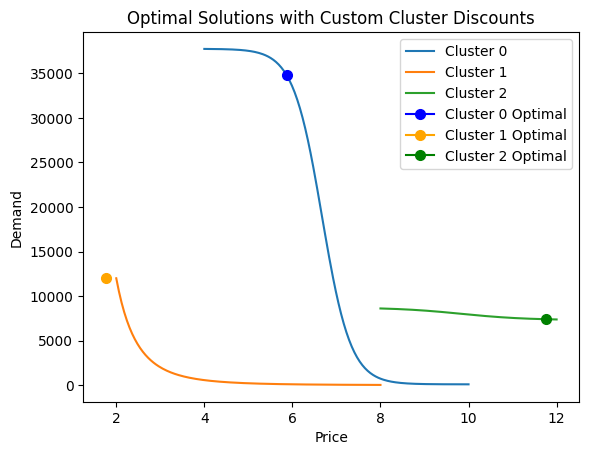

In [50]:
plt.plot(prices0,demand0)
plt.plot(prices1,demand1)
plt.plot(prices2,demand2)
plt.plot(OptPrices[0],OptDemand[0],marker="o", markersize=7, color="Blue")
plt.plot(OptPrices[1],OptDemand[1],marker="o", markersize=7, color="Orange")
plt.plot(OptPrices[2],OptDemand[2],marker="o", markersize=7, color="Green")
plt.ylabel('Demand')
plt.xlabel('Price')
plt.title('Optimal Solutions with Custom Cluster Discounts')

plt.legend(['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 0 Optimal','Cluster 1 Optimal','Cluster 2 Optimal'])

# Single Pricing Model

In [51]:
maxRev = 0
optBase = 2
OptDemand = [0,0,0]
OptPrices = [0,0,0]

start = 2
end = 12
spacing = (end-start)*100 + 1

for basePrice in np.linspace(start, end, spacing):

    index0 = np.argmin(np.abs(np.array(prices0)- (basePrice)))
    index1 = np.argmin(np.abs(np.array(prices1)- (basePrice)))
    index2 = np.argmin(np.abs(np.array(prices2)- (basePrice)))

    Dvar0 = demand0[index0]
    Dvar1 = demand1[index1]
    Dvar2 = demand2[index2]

    if index0 == len(prices0): Dvar0 = 0
    if index1 == len(prices1): Dvar1 = 0
    if index2 == len(prices2): Dvar1 = 0

    Revenue = Dvar0*basePrice + Dvar1*basePrice + Dvar2*basePrice
    sumD = Dvar0 +Dvar1 + Dvar2

    if Revenue >= maxRev:
        if sumD <= 20000:
            maxRev = solution
            optBase = basePrice
            demands = [round(Dvar0,2),round(Dvar1,2),round(Dvar2,2)]

In [52]:
print('Optimal Price:', optBase)
print('Maximum Revenue:', maxRev)
print('Cluster Demands', demands)

Optimal Price: 6.94
Maximum Revenue: 311796.2378891182
Cluster Demands [11271.18, 49.52, 8610.97]
